In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
from statistics import mean

In [ ]:
# #Load Dataset MEGA M
# from google.colab import drive
# %cd /content/drive/MyDrive/Dataset_TA/MEGA/Monthly
# %ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset_TA/MEGA/Monthly'
/content
'MEGA M.csv'   sample_data/


In [ ]:
# %ls /content/drive/MyDrive/Dataset_TA/MEGA

ls: cannot access '/content/drive/MyDrive/Dataset_TA/MEGA': No such file or directory


In [ ]:
data = pd.read_csv('MEGA M.csv')
data

,Tanggal,Laba Rugi
0,January 2011,55761
1,February 2011,134001
2,March 2011,241886
3,April 2011,318652
4,May 2011,386858
...,...,...
127,August 2021,2127526
128,September 2021,2196985
129,October 2021,2489114
130,November 2021,2786330


# Preprocessing

In [ ]:
def transform(data):
  j = 0
  k = j + 11
  while k <= len(data):
    l = k
    while l != j :
      a = data["Laba Rugi"][l] - data["Laba Rugi"][l-1]
      data["Laba Rugi"][l] = a
      l -= 1
    j = k + 1
    k = j + 11
    
  return data

data = transform(data)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Tanggal,Laba Rugi
0,January 2011,55761
1,February 2011,78240
2,March 2011,107885
3,April 2011,76766
4,May 2011,68206
...,...,...
127,August 2021,534335
128,September 2021,69459
129,October 2021,292129
130,November 2021,297216


In [ ]:
# data.to_excel('transformed data BBRI M.xlsx')

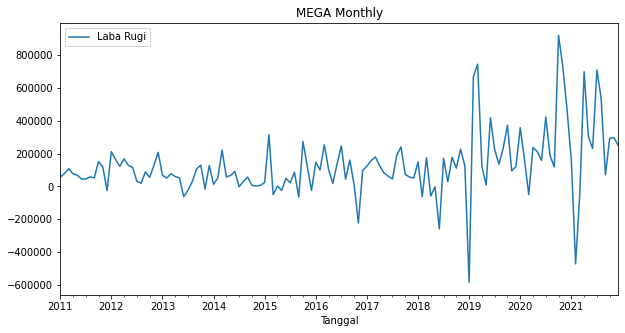

In [ ]:
data.index = pd.to_datetime(data.Tanggal)
data.drop(["Tanggal"], axis=1, inplace=True)
data.plot(title="MEGA Monthly", figsize=(10,5))

In [ ]:
scaler = MinMaxScaler()

data[['Laba Rugi']] = scaler.fit_transform(data[['Laba Rugi']])
data

,Laba Rugi
Tanggal,
2011-01-01,0.425737
2011-02-01,0.440666
2011-03-01,0.460354
2011-04-01,0.439687
2011-05-01,0.434002
...,...
2021-08-01,0.743565
2021-09-01,0.434834
2021-10-01,0.582713


In [ ]:
#Train : Test -> 75 : 25
split = int(round(len(data)*.75,0))
data_train = data[:split] #time series as train data (75%)
data_test = data[split:] #time series as test data (25%)

#Train : Test -> 50 : 50
# split = int(round(len(data)*.5,0))
# data_train = data[:split] #time series as train data (50%)
# data_test = data[split:] #time series as test data (50%)

data_train_arr = data_train.to_numpy()
data_test_arr = data_test.to_numpy()

train = np.reshape(data_train_arr, (data_train_arr.shape[0]))
test = np.reshape(data_test_arr, (data_test_arr.shape[0]))

In [ ]:
print("% data test: ", len(data_test)/len(data)*100)

% data test:  25.0


In [ ]:
#input sampling timeseries
n_sampling = 12

def split_sequence(sequence, n_steps):
	_X, _y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		_X.append(seq_x)
		_y.append(seq_y)
	return np.array(_X), np.array(_y)

x_train, y_train = split_sequence(train, n_sampling)
x_test, y_test = split_sequence(test, n_sampling)

# Combined

Training

In [ ]:
#define param
n = n_sampling
input = n + 1
layer1 = 13
# layer2 = 39
output = 1
learning_rate = 0.007
epoch = 90

tf.random.set_seed(100)

#define Optimizer
adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

# define model
model5 = Sequential()
model5.add(Dense(input, activation='relu', input_dim=n))
model5.add(Dense(layer1, activation='relu'))
# model5.add(Dense(layer2, activation='relu'))
model5.add(Dense(output, activation='linear'))
model5.compile(optimizer=adam, loss='mse')

# fit model 
history = model5.fit(x_train, y_train, epochs=epoch, verbose=0)

In [ ]:
#alasan pilih parameter tersebut adalah mencari yang paling seimbang antara loss, volatilitas pada seluruh data, dan simplicity

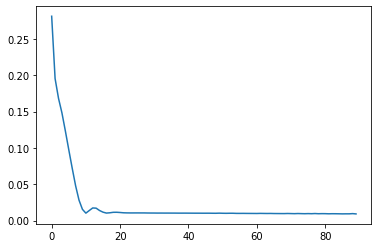

In [ ]:
plt.plot(history.history['loss'])

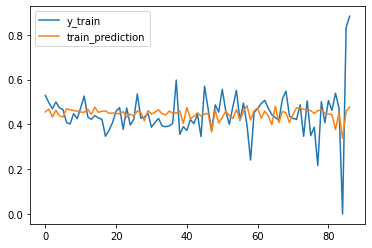

In [ ]:
# plot train model
train_prediction = model5.predict(x_train, verbose=0)

train_prediction = np.reshape(train_prediction, (train_prediction.shape[0]))

Tanggal = data[:split].index.to_numpy()
Tanggal = Tanggal[n_sampling:]

#Plot test and prediction model
y_PD =  pd.DataFrame(data={'Tanggal':Tanggal, 'y_train':y_train},   
              index=Tanggal,    
              columns=['Tanggal', 'y_train'])  

train_prediction_PD = pd.DataFrame(data={'Tanggal':Tanggal, 'train_prediction':train_prediction},   
              index=Tanggal,    
              columns=['Tanggal', 'train_prediction']) 

Final_PD = pd.merge(y_PD, train_prediction_PD, on='Tanggal', how='left')

Final_PD[['y_train','train_prediction']].plot()

In [ ]:
# Final_PD.index = pd.to_datetime(Final_PD.Tanggal)
# Final_PD.drop(["Tanggal"], axis=1, inplace=True)

# Final_PD_inv = scaler.inverse_transform(Final_PD)
# Final_PD_model = pd.DataFrame(Final_PD_inv, columns = ['y_train','train_prediction'])

# Final_PD_model.to_excel('Training Result v3 n_sampling=12 MEGA Monthly.xlsx')

In [ ]:
y_PD.drop(["Tanggal"], axis=1, inplace=True)
train_prediction_PD.drop(["Tanggal"], axis=1, inplace=True)

y_PD_arr = y_PD.to_numpy()
y_prediction_PD_arr = train_prediction_PD.to_numpy()

In [ ]:
mse = mean_squared_error(y_PD_arr, y_prediction_PD_arr)
print("Akurasi", (1-mse))
print("MSE: ", mse)

Akurasi 0.9907581464756399
MSE:  0.009241853524360077


In [ ]:
#Train 75 25 MSE=0.009241853524360077
#Train 50 50 MSE=0.0030943594076054616

Testing

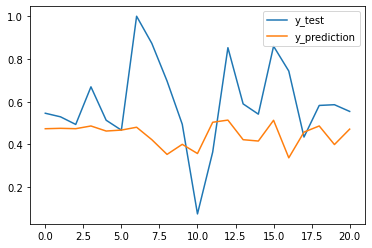

In [ ]:
# test model
y_prediction = model5.predict(x_test, verbose=0)

y_prediction = np.reshape(y_prediction, (y_prediction.shape[0]))

Tanggal = data[split:].index.to_numpy()
Tanggal = Tanggal[n_sampling:]

#Plot test and prediction model
y_PD =  pd.DataFrame(data={'Tanggal':Tanggal, 'y_test':y_test},   
              index=Tanggal,    
              columns=['Tanggal', 'y_test'])  

y_prediction_PD = pd.DataFrame(data={'Tanggal':Tanggal, 'y_prediction':y_prediction},   
              index=Tanggal,    
              columns=['Tanggal', 'y_prediction']) 

Final_PD = pd.merge(y_PD, y_prediction_PD, on='Tanggal', how='left')

Final_PD[['y_test','y_prediction']].plot()

In [ ]:
# Final_PD.index = pd.to_datetime(Final_PD.Tanggal)
# Final_PD.drop(["Tanggal"], axis=1, inplace=True)

# Final_PD_inv = scaler.inverse_transform(Final_PD)
# Final_PD_model = pd.DataFrame(Final_PD_inv, columns = ['Actual Test Data','Prediction Test Data'])

# Final_PD_model.to_excel('Prediction Result v3 n_sampling=12 MEGA Monthly.xlsx')

Mean Square Error

In [ ]:
y_PD.drop(["Tanggal"], axis=1, inplace=True)
y_prediction_PD.drop(["Tanggal"], axis=1, inplace=True)

y_PD_arr = y_PD.to_numpy()
y_prediction_PD_arr = y_prediction_PD.to_numpy()

In [ ]:
mse = mean_squared_error(y_PD_arr, y_prediction_PD_arr)
print("Akurasi", (1-mse))
print("MSE: ", mse)

Akurasi 0.9410532626047884
MSE:  0.058946737395211585


In [ ]:
#Test 75 25 MSE=0.058946737395211585
#Test 50 50 MSE=0.035151542614513254

Export Final Model

In [ ]:
# #export model using pickel
# import pickle

# #save model to disk
# filename = 'MEGA M 60 0.005 50 mse=0.004772.sav'
# pickle.dump(model5, open(filename, 'wb'))

# # load the model from disk
# # loaded_model = pickle.load(open(filename, 'rb'))
# # result = loaded_model.score(X_test, Y_test)
# # print(result)

INFO:tensorflow:Assets written to: ram://84bbe153-89fd-43e9-bb8a-39002433a621/assets


In [ ]:
# #export model using joblib
# import joblib

# # save the model to disk
# # filename = 'finalized_model.sav'
# # joblib.dump(model, filename)

# # load the model from disk
# model_name = 'BBRI M 8 0.008 161 loss=0.00609.sav'
# loaded_model = joblib.load(model_name)
# # result = loaded_model.predict(x_test, y_test)
# # print(result)

In [ ]:
# loaded_model.weights

[<tf.Variable 'dense_13/kernel:0' shape=(5, 6) dtype=float32, numpy=
 array([[ 0.4728928 , -0.20804167, -0.8398208 , -0.6216376 ,  0.24435224,
          0.18924084],
        [ 0.1258476 , -0.82959116, -0.26968738, -0.5856874 ,  1.1913812 ,
         -0.5835206 ],
        [ 0.23100875, -0.22577332,  0.80493826,  0.0448702 , -0.10766881,
          0.72420526],
        [ 0.37208772,  0.36150286,  0.10642855, -0.5134552 ,  0.21437846,
         -0.09376506],
        [ 0.6509784 , -0.6006384 , -0.47103286, -0.35389954,  0.3349238 ,
          0.4597595 ]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(6,) dtype=float32, numpy=
 array([-0.03140027, -0.10985053, -0.1374046 ,  0.        , -0.09625794,
         0.07550149], dtype=float32)>,
 <tf.Variable 'dense_14/kernel:0' shape=(6, 8) dtype=float32, numpy=
 array([[-0.13460448,  0.21763717,  0.7874137 , -0.2642669 , -0.66650474,
         -0.41222557,  0.4523649 ,  0.19247651],
        [ 0.21431172, -0.05113324,  0.46321395,  0.03421104